# Build a Traffic Sign Recognition Classifier

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import os
import glob
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import cv2
from keras.preprocessing.image import ImageDataGenerator
from random import randint

(397, 239, 3)


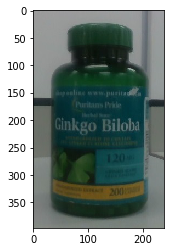

In [111]:
img = plt.imread('realsense-cam/training_data/20181008-141638_color.jpg')
plt.imshow(img)
print(img.shape)

In [4]:
rgb2gray = [0.299, 0.587, 0.114]

img_dir = "realsense-cam/training_data/"
data = pd.read_csv(img_dir+'label.csv')

X_train = []
y_train = []

image_size = (96,96)
for i in range(len(data)):
    filename = data.iloc[i,0]
    label = data.iloc[i,1]
    if label == 'ovaltine':
        label = 0
    elif label == 'ginkgo':
        label = 1
    elif label == 'babydream':
        label = 2
    elif label == 'lavie':
        label = 3
    
    img = plt.imread(img_dir+filename)
    img = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)
    X_train.append(img)
    y_train.append(label)
    
X_train = np.array(X_train)
print(X_train.shape)

(73, 96, 96, 3)


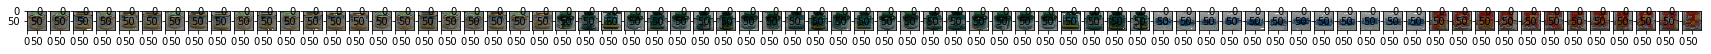

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
plt.figure(figsize=(30,15))
i = 0
for img in X_train:
    i+=1
    plt.subplot(1,len(X_train),i)
    plt.imshow(img)        
                    
plt.show()

print(y_train)

In [6]:
n_train = X_train.shape[0]
n_classes = max(y_train) + 1

In [7]:
rgb2gray = [0.299, 0.587, 0.114]
# Convert images to grayscale
X_train_gray = np.dot(X_train[...,:3], rgb2gray)

# Normalize images
X_train_gray = (X_train_gray/255-0.5)*2
X_train_gray = X_train_gray.reshape(*X_train_gray.shape, 1)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10,zoom_range=0.10)
for x_batch, y_batch in datagen.flow(X_train_gray, y_train, batch_size=X_train_gray.shape[0], shuffle=False):
    X_train_aug = x_batch.astype('uint8')
    y_train_aug = y_batch
    break

X_train_gray = np.concatenate([X_train_gray, X_train_aug])
y_train = np.concatenate([y_train,y_train_aug])

In [10]:
#@title
def LeNet(x):
    mu = 0
    sigma = 0.1
    
#     LeNet: Input 96x96x1, 92x92x6, 46x46x6, 40x40x16, 20x20x16, 16x16x16,, 8x8x16, 1024, 512, 128, 32, n_classes
    weights = {
        'conv1_W' : tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma)),
        'conv2_W' : tf.Variable(tf.truncated_normal(shape=(7,7,6,16), mean=mu, stddev=sigma)),
        'conv3_W' : tf.Variable(tf.truncated_normal(shape=(5,5,16,16), mean=mu, stddev=sigma)),
        'fc1_W' : tf.Variable(tf.truncated_normal(shape=(1024,512), mean=mu, stddev=sigma)),
        'fc2_W' : tf.Variable(tf.truncated_normal(shape=(512,128), mean=mu, stddev=sigma)),
        'fc3_W' : tf.Variable(tf.truncated_normal(shape=(128,32), mean=mu, stddev=sigma)),
        'fc4_W' : tf.Variable(tf.truncated_normal(shape=(32,n_classes), mean=mu, stddev=sigma))

    }
    
    biases = {
        'conv1_b' : tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'conv2_b' : tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma)),
        'conv3_b' : tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma)),
        'fc1_b' : tf.Variable(tf.truncated_normal([512], mean=mu, stddev=sigma)),
        'fc2_b' : tf.Variable(tf.truncated_normal([128], mean=mu,stddev=sigma)),
        'fc3_b' : tf.Variable(tf.truncated_normal([32], mean=mu, stddev=sigma)),
        'fc4_b' : tf.Variable(tf.truncated_normal([n_classes], mean=mu,stddev=sigma))
    }
    
    conv1 = tf.nn.conv2d(x, weights['conv1_W'], strides=[1,1,1,1], padding='VALID') + biases['conv1_b']
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    conv2 = tf.nn.conv2d(conv1, weights['conv2_W'], strides=[1,1,1,1], padding='VALID') + biases['conv2_b']
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    conv3 = tf.nn.conv2d(conv2, weights['conv3_W'], strides=[1,1,1,1], padding='VALID') + biases['conv3_b']
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
                                
                                
    fc0 = flatten(conv3)
    
    fc1 = tf.matmul(fc0, weights['fc1_W']) + biases['fc1_b']
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.matmul(fc1, weights['fc2_W']) + biases['fc2_b']
    fc2 = tf.nn.relu(fc2)
                                
    fc3 = tf.matmul(fc2, weights['fc3_W']) + biases['fc3_b']
    fc3 = tf.nn.relu(fc3)
    
    logits = tf.matmul(fc3, weights['fc4_W']) + biases['fc4_b']
    
    return logits

In [11]:
x = tf.placeholder(tf.float32, (None, 96, 96, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

learning_rate = 0.001
EPOCHS = 30
BATCH_SIZE = 256

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy*len(batch_x))
    return total_accuracy/num_examples,logits

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)

    for i in range(EPOCHS):
        X_train_gray, y_train = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray[offset:end], y_train[offset:end]
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy,_ = evaluate(X_train_gray, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './LeNet')

EPOCH 1 ...
Validation Accuracy = 0.452
EPOCH 2 ...
Validation Accuracy = 0.459
EPOCH 3 ...
Validation Accuracy = 0.514
EPOCH 4 ...
Validation Accuracy = 0.521
EPOCH 5 ...
Validation Accuracy = 0.562
EPOCH 6 ...
Validation Accuracy = 0.568
EPOCH 7 ...
Validation Accuracy = 0.568
EPOCH 8 ...
Validation Accuracy = 0.630
EPOCH 9 ...
Validation Accuracy = 0.651
EPOCH 10 ...
Validation Accuracy = 0.610
EPOCH 11 ...
Validation Accuracy = 0.658
EPOCH 12 ...
Validation Accuracy = 0.651
EPOCH 13 ...
Validation Accuracy = 0.678
EPOCH 14 ...
Validation Accuracy = 0.678
EPOCH 15 ...
Validation Accuracy = 0.671
EPOCH 16 ...
Validation Accuracy = 0.651
EPOCH 17 ...
Validation Accuracy = 0.678
EPOCH 18 ...
Validation Accuracy = 0.678
EPOCH 19 ...
Validation Accuracy = 0.678
EPOCH 20 ...
Validation Accuracy = 0.678
EPOCH 21 ...
Validation Accuracy = 0.678
EPOCH 22 ...
Validation Accuracy = 0.678
EPOCH 23 ...
Validation Accuracy = 0.658
EPOCH 24 ...
Validation Accuracy = 0.678
EPOCH 25 ...
Validation A

In [0]:
# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('.'))
    
#     test_accuracy,logits = evaluate(X_test_gray, y_test)
#     print("Test Accuracy = {:.3f}".format(test_accuracy))

In [102]:
def classifier(dataset,n):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        output = sess.run(tf.nn.top_k(logits, k=2), feed_dict={x: dataset})
        bottleId = []
        for i in range(n-1):
            bottleId.append(output[1][i][0])
            print("Output: ",bottleId[0])
#       print("Sign name: ",sign_name[signId][0])
#   for sign in signId:
#     plt.imshow(signs[sign])
#     plt.grid(b=None)
#     plt.tick_params(labelbottom=False,labelleft=False)


def randomImages():
    dataset = []
    rgb2gray = [0.299, 0.587, 0.114]
    %matplotlib inline
    fig = plt.figure(figsize=(20,5))
    n = 2
    for i in range(1,n):
        img = X_train[randint(0,n_train),:,:,:]
        fig.add_subplot(1,n-1,i)
        plt.imshow(img)
        plt.grid(b=None)
        plt.tick_params(labelbottom=False,labelleft=False)
        dataset.append(img)
    plt.show()
    dataset = np.array(dataset,dtype=np.float32)
    dataset = np.dot(dataset[...,:3], rgb2gray)
    dataset = (dataset/255-0.5)*2
    dataset = dataset.reshape(*dataset.shape, 1)
    return dataset,n

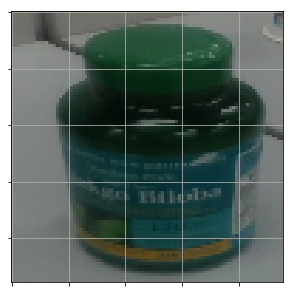

In [103]:
dataset,n = randomImages()

In [104]:
classifier(dataset,n)

INFO:tensorflow:Restoring parameters from .\LeNet
Output:  1


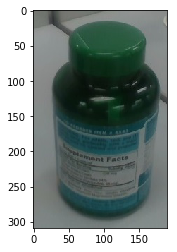

In [108]:
img = plt.imread('realsense-cam/ginkgo biloba - cropped/color20181008-142100.jpg')
plt.imshow(img)
img = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)

rgb2gray = [0.299, 0.587, 0.114]
dataset = []
dataset.append(img)
dataset = np.array(dataset,dtype=np.float32)
dataset = np.dot(dataset[...,:3], rgb2gray)
dataset = (dataset/255-0.5)*2
dataset = dataset.reshape(*dataset.shape, 1)

In [109]:
classifier(dataset,2)

INFO:tensorflow:Restoring parameters from .\LeNet
Output:  1
